<a href="https://colab.research.google.com/github/Satvik256/TestRepo/blob/master/SGD_with_momentum_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%matplotlib inline
from fastai.basics import *
from fastai.vision import *

In [0]:
with gzip.open('/content/mnist.pkl.gz', 'rb') as f:
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')

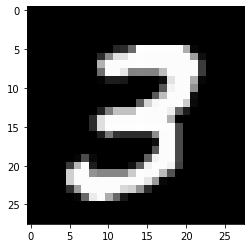

In [5]:
plt.imshow(x_train[7].reshape(28,28),cmap='gray')

In [0]:
x_train=torch.from_numpy(x_train)
x_valid=torch.from_numpy(x_valid)
y_train=torch.from_numpy(y_train)
y_valid=torch.from_numpy(y_valid)

In [0]:
train_ds=TensorDataset(x_train,y_train)
valid_ds=TensorDataset(x_valid,y_valid)

In [0]:
data=DataBunch.create(train_ds,valid_ds,bs=64)

In [0]:
x,y=next(iter(data.train_dl))

In [10]:
x.shape,y.shape

(torch.Size([64, 784]), torch.Size([64]))

In [0]:
class mnist_nn(nn.Module):
  def __init__(self):
    super().__init__()
    self.lin1=nn.Linear(784,60)
    self.lin2=nn.Linear(60,10)
  def forward(self,minibatch):
    x=self.lin1(minibatch)    
    F.relu_(x)
    x=self.lin2(x)
    # torch.sigmoid_(x)
    return x

In [0]:
model=mnist_nn().cuda()

In [0]:
loss_function=nn.CrossEntropyLoss()

In [0]:
def update(x,y,lr):
  opt=optim.SGD(model.parameters(),lr,weight_decay=1e-5,momentum=0.9)
  y_pred=model(x)
  loss=loss_function(y_pred,y)
  loss.backward()
  opt.step()
  opt.zero_grad()
  return loss.item()

In [0]:
loss_sgd=[update(x,y,4e-2) for x,y in data.train_dl]

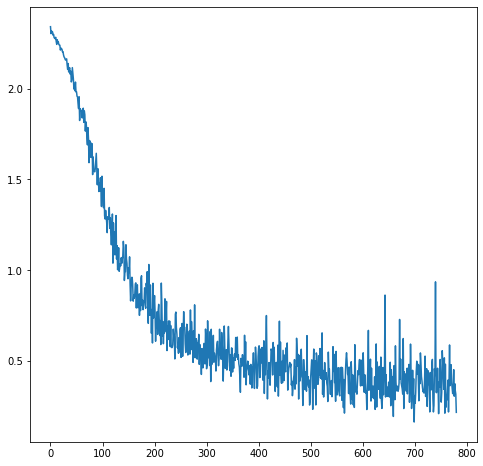

In [216]:
plt.figure(figsize=(8,8))
plt.plot(loss_sgd);

In [217]:
min(loss_sgd)

0.16348299384117126

In [0]:
previous=[]

In [0]:
for p in model.parameters():
  temp_tensor=torch.cuda.FloatTensor(p.shape).fill_(0)
  previous.append(temp_tensor)

In [0]:
model=mnist_nn().cuda()

In [0]:
def update_scratch(lr):
  loss_list=[]
  for a,b in data.train_dl:
    x=a
    y=b
    wd=1e-5
    y_pred=model(x)
    w2=0
    for p in model.parameters():w2+=(p**2).sum()
    loss=loss_function(y_pred,y)+w2*wd
    loss.backward()
    with torch.no_grad():
      i=0
      for p in model.parameters():
        p-=((lr*p.grad)*0.1)+(previous[i]*0.9)
        previous_tmp=((lr*p.grad)*0.1)+(previous[i]*0.9)
        previous[i]=previous_tmp
        i+=1
        p.grad.zero_()
    loss_list.append(loss.item())
  return loss_list  

In [0]:
tmp=update_scratch(4e-2)

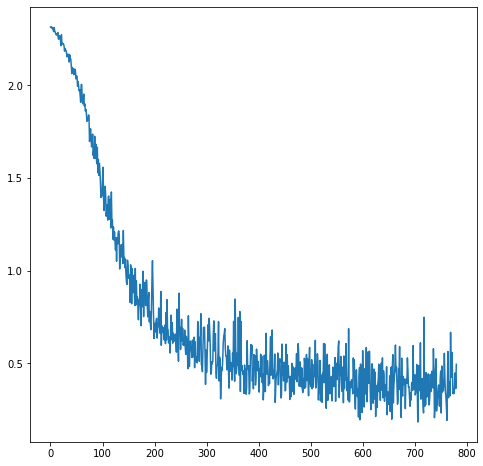

In [211]:
plt.figure(figsize=(8,8))
plt.plot(tmp)

In [212]:
min(tmp)

0.18441306054592133